In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pyecharts.charts import Bar,Grid,Line,Pie
from pyecharts import options as opts
from pyecharts.globals import ThemeType
from pyecharts.commons.utils import JsCode
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold
from lightgbm.sklearn import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time

In [3]:
movies1 =  pd.read_csv("movies_piaofang.csv")
movies2 =  pd.read_csv("movies_pingfen.csv")
movie_sum= pd.concat([movies1,movies2])

In [4]:
fea = ["release_date","directedBy","starring","genre","runtime","country","rating_num","vote_num","comment_num"]
movies=movie_sum[fea]
movies.head(1)
movies["directedBy"]= movies["directedBy"].apply(lambda x: x[1:-1].replace(" ","").split(","))
movies["starring"] = movies["starring"].apply(lambda x: x[1:-1].replace(" ","").split(","))
movies["genre"]=movies["genre"].apply(lambda x: x[1:-1].replace(" ","").split(","))

In [5]:
dirs = ['史蒂文·斯皮尔伯格',
 '克里斯托弗·诺兰',
 '彼得·杰克逊',
 '迈克尔·贝',
 '宫崎骏',
 '大卫·叶茨',
 '王家卫',
 '李·昂克里奇',
 '盖·里奇',
 '乔·罗素',]
stars=['乔恩·费儒',
 '姜文',
 '周星驰',
 '迈克·米切尔',
 '皮埃尔·柯芬',
 '鲍勃·彼德森',
 '克林特·伊斯特伍德',
 '安德鲁·斯坦顿',
 '克里斯·雷纳德',
 '凯文·科斯特纳',]
gens=["剧情","爱情","喜剧","犯罪","冒险"]
cons =["美国","英国","日本","法国","中国大陆","中国香港","中国台湾","香港","台湾"]
movies.index= range(len(movies))
movies

,release_date,directedBy,starring,genre,runtime,country,rating_num,vote_num,comment_num
0,2019,"['安东尼·罗素', '乔·罗素']","['小罗伯特·唐尼', '克里斯·埃文斯', '马克·鲁弗洛', '克里斯·海姆斯沃斯', ...","['剧情', '动作', '科幻', '奇幻', '冒险']",181,美国,8.5,923023,314581
1,2009,['詹姆斯·卡梅隆'],"['萨姆·沃辛顿', '佐伊·索尔达娜', '西格妮·韦弗', '史蒂芬·朗', '米歇尔·...","['动作', '科幻', '冒险']",162,美国 / 英国,8.7,1046959,206783
2,1997,['詹姆斯·卡梅隆'],"['莱昂纳多·迪卡普里奥', '凯特·温丝莱特', '比利·赞恩', '凯西·贝茨', '弗...","['剧情', '爱情', '灾难']",194,美国,9.4,1693601,328281
3,2015,['J·J·艾布拉姆斯'],"['哈里森·福特', '马克·哈米尔', '凯丽·费雪', '亚当·德赖弗', '黛西·雷德...","['动作', '科幻', '冒险']",135,美国,7.2,196795,60634
4,2018,"['安东尼·罗素', '乔·罗素']","['小罗伯特·唐尼', '克里斯·海姆斯沃斯', '克里斯·埃文斯', '马克·鲁弗洛', ...","['动作', '科幻', '奇幻', '冒险']",149,美国,8.1,695008,226207
...,...,...,...,...,...,...,...,...,...
490,2002,['易智言'],"['陈柏霖', '桂纶镁', '梁又琳', '仇政', '明金成', '林贤能', '黄江丰...","['剧情', '爱情', '同性']",85,台湾 / 法国,8.3,264174,68627
491,2007,['约翰·卡尼'],"['格伦·汉塞德', '玛可塔·伊尔格洛娃']","['剧情', '爱情', '音乐']",85,爱尔兰,8.3,195666,59606
492,2001,['大卫·林奇'],"['娜奥米·沃茨', '劳拉·哈灵', '安·米勒', '贾斯汀·塞洛克斯', '斯科特·科...","['剧情', '悬疑', '惊悚']",147,法国 / 美国,8.3,224077,75866
493,2009,['克里斯托弗·史密斯'],"['梅利莎·乔治', '利亚姆·海姆斯沃斯', '迈克尔·多曼', '瑞秋·卡帕尼', '艾...","['剧情', '悬疑', '惊悚']",99,英国 / 澳大利亚,8.3,303980,90752


In [6]:
movies.loc[[1,2,4]]

,release_date,directedBy,starring,genre,runtime,country,rating_num,vote_num,comment_num
1,2009,['詹姆斯·卡梅隆'],"['萨姆·沃辛顿', '佐伊·索尔达娜', '西格妮·韦弗', '史蒂芬·朗', '米歇尔·...","['动作', '科幻', '冒险']",162,美国 / 英国,8.7,1046959,206783
2,1997,['詹姆斯·卡梅隆'],"['莱昂纳多·迪卡普里奥', '凯特·温丝莱特', '比利·赞恩', '凯西·贝茨', '弗...","['剧情', '爱情', '灾难']",194,美国,9.4,1693601,328281
4,2018,"['安东尼·罗素', '乔·罗素']","['小罗伯特·唐尼', '克里斯·海姆斯沃斯', '克里斯·埃文斯', '马克·鲁弗洛', ...","['动作', '科幻', '奇幻', '冒险']",149,美国,8.1,695008,226207


In [7]:
for i in range(495):
    temp = movies.loc[i]["country"].replace(" ","").split("/")
    for j1 in range(len(cons)):
        ids = "c"+str(j1)
        if(j1>3):
            if cons[j1] in temp:
                movies.loc[i,"c4"] = 1 
            else:
                movies.loc[i,"c4"] = 0
        else:
            if cons[j1] in temp:
                movies.loc[i,ids] = 1 
            else:
                movies.loc[i,ids] = 0


In [8]:
def fea_create(list_fea,which_fea,name):
    for i in range(495):
        for j1 in range(len(list_fea)):
            ids = name+str(j1)
            if "'"+list_fea[j1]+"'" in movies.loc[i][which_fea]:
                movies.loc[i,ids] = 1
            else:
                movies.loc[i,ids] = 0
fea_create(dirs,"directedBy","d")
fea_create(stars,"starring","s")
fea_create(gens,"genre","g")


In [11]:
# #类别特征取值较少的，画出直方图,
df  =  movies.drop(["directedBy","starring","genre","country"],axis=1).copy()
# cat_fea = df.columns.tolist()
# plt.figure()
# plt.figure(figsize=(16, 30))
# i = 1
# for fea in [cat_fea]:
#     if df[fea].nunique()<20:
#         plt.subplot(10, 5, i)
#         i += 1
#         v = df[fea].value_counts()
#         fig = sns.barplot(x=v.index, y=v.values)
#         for item in fig.get_xticklabels():
#             item.set_rotation(90)
#         plt.title(fea)
# plt.tight_layout()
# plt.show()


<Figure size 432x288 with 0 Axes>

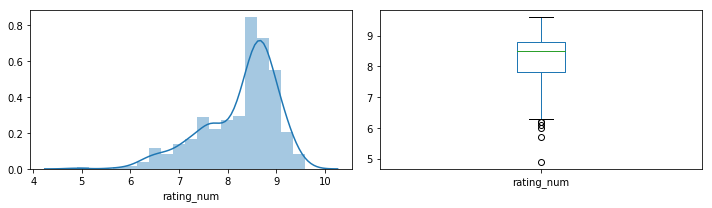

In [12]:
plt.figure()
plt.figure(figsize=(10, 3))
plt.subplot(1, 2,1)
sns.distplot(df['rating_num'])
plt.subplot(1,2,2)
df['rating_num'].plot.box()
plt.tight_layout()

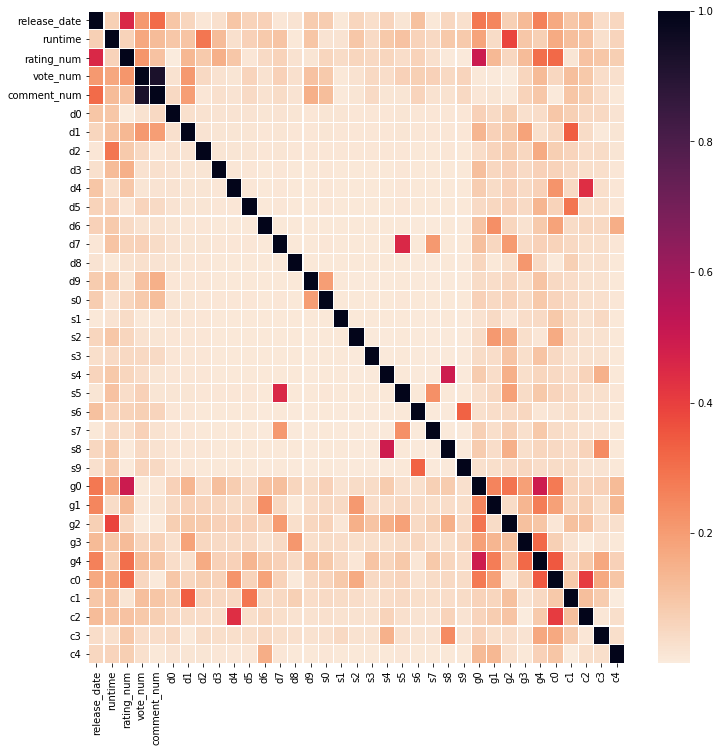

In [13]:
choice_f = ['release_date', 'runtime', 
       'rating_num', 'vote_num', 'comment_num', 'd0', 'd1', 'd2', 'd3', 'd4',
       'd5', 'd6', 'd7', 'd8', 'd9', 's0', 's1', 's2', 's3', 's4', 's5', 's6',
       's7', 's8', 's9', 'g0', 'g1', 'g2', 'g3', 'g4', 'c0', 'c1', 'c2', 'c3',
       'c4']
corr1 = abs(movies[choice_f].corr())
plt.figure(figsize=(12, 12))
sns.heatmap(corr1, linewidths=0.1, cmap=sns.cm.rocket_r)

In [14]:
import random
random.seed(200)
al = range(495) 
sub = random.sample(al,400)
sub_ = [ i for i in al if i not in sub ]

In [15]:
data  =  movies.drop(["directedBy","starring","genre","country"],axis=1).copy()
X_train = data.loc[sub].drop(["rating_num"],axis=1)
Y_train = data.loc[sub]["rating_num"]
X_test = data.loc[sub_].drop(["rating_num"],axis=1)
Y_test = data.loc[sub_]["rating_num"]

In [16]:
index = Y_train.index.tolist()
subsample_index = random.sample(index,50)


MAE:0.413985
The predicted price is obvious different from true price


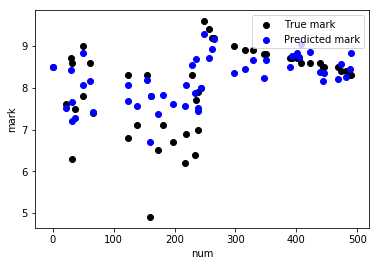

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,  make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
lr = LinearRegression(normalize=True)
model = lr.fit(X_train, Y_train)
print("MAE:%f"%mean_absolute_error(Y_test,model.predict(X_test)))
index = Y_train.index.tolist()
subsample_index = random.sample(index,50)
plt.scatter(X_train.loc[subsample_index].index, Y_train.loc[subsample_index], color='black')
plt.scatter(X_train.loc[subsample_index].index, model.predict(X_train.loc[subsample_index]), color='blue')
plt.xlabel('num')
plt.ylabel('mark')
plt.legend(['True mark','Predicted mark'],loc='upper right')
print('The predicted price is obvious different from true price')
plt.show()

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR,LinearSVR
svm =SVR(kernel='linear',degree = 1,coef0 = 0.1,
                    tol = 0.1,C = 1,epsilon = 0.5,shrinking = True,
                 cache_size = 200,verbose = False,max_iter = -1)
svm.fit(X_train,Y_train)
print("MAE:%f"%mean_absolute_error(Y_test,svm.predict(X_test)))

KeyboardInterrupt: 

In [ ]:
# from sklearn.model_selection import GridSearchCV
clf = LGBMRegressor(
    n_estimators=200,
    learning_rate=0.07,
    boosting_type= 'gbdt',
    objective = 'regression_l1',
    max_depth = 11,
    num_leaves=31,
    min_child_samples = 10,
    feature_fraction = 0.9,
    bagging_freq = 0,
    bagging_fraction = 0.9,
    lambda_l2 = 2,
#     random_state=2021,
    metric='mae'
)
# gsearch = GridSearchCV(clf, param_grid=params, scoring="neg_mean_absolute_error" , cv=3, verbose=300)
# gsearch.fit(X_train, Y_train)
clf.fit(
        X_train, Y_train,
        verbose=300
    )
mae_lgbm=mean_absolute_error(Y_test,clf.predict(X_test))
print("MAE:%f"%mae_lgbm)

In [ ]:
import xgboost as xgb
xgb = xgb.XGBRegressor(
    n_estimators=200, 
    learning_rate=0.03, 
    gamma=0, 
    subsample=0.7,
    colsample_bytree=0.9,
    max_depth=11,
    ) 
xgb.fit(
        X_train, Y_train,
        verbose=200
    )
mae_xgb=mean_absolute_error(Y_test,xgb.predict(X_test))
print("MAE:%f"%mae_xgb)

In [ ]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV

X_mix_train = pd.concat([pd.DataFrame(xgb.predict(X_train)),pd.DataFrame(clf.predict(X_train))],axis=1)
X_mix_train.columns = ["xgb","lgbm"]
X_mix_test = pd.concat([pd.DataFrame(xgb.predict(X_test)),pd.DataFrame(clf.predict(X_test))],axis=1)
X_mix_test.columns = ["xgb","lgbm"]
alpha_can = np.logspace(-3, 0, 10)

# lr2 = LinearRegression(fit_intercept=True)
model1 =Ridge(alpha=10, copy_X=True, fit_intercept=True,normalize=False, solver='auto')
model2= Lasso(alpha=0.01, copy_X=True, fit_intercept=True,normalize=False)
model3 = LinearRegression(fit_intercept=True)
model1 = model1.fit(X_mix_train, Y_train)
model2 = model2.fit(X_mix_train, Y_train)
model3 = model3.fit(X_mix_train, Y_train)

print("MAE:%f"%mean_absolute_error(Y_test,model1.predict(X_mix_test)))
print("MAE:%f"%mean_absolute_error(Y_test,model2.predict(X_mix_test)))
print("MAE:%f"%mean_absolute_error(Y_test,model3.predict(X_mix_test)))

# print(model2.coef_)
# pre_mix =pd.concat([pd.DataFrame(model2.predict(X_mix_train)),X_mix_train,Y_train],axis=1)

In [ ]:
mix = pd.DataFrame()
mix['LR']=model.predict(X_test)

mix["xgb"] = X_mix_test["xgb"]
mix["lgbm"] = X_mix_test["lgbm"]

mix["mean"] =  X_mix_test["xgb"]*(mae_lgbm/(mae_lgbm+mae_xgb))+ X_mix_test["lgbm"]*(mae_xgb/(mae_lgbm+mae_xgb))
mix["ridge_m"] = model1.predict(X_mix_test)
mix["LR_m"] = model3.predict(X_mix_test)
mix["lasso_m"] = model2.predict(X_mix_test)
# print("MAE:%f"%mean_absolute_error(Y_test,mix["pre"]))
mix["true"]  = pd.DataFrame(Y_test).reset_index(drop=True)
mix

In [ ]:
index = mix.index.tolist()
random.seed(2)
subsample_index = random.sample(index,50)
plt.figure(figsize=(15, 10))
plt.subplot(3, 3, 1)
plt.scatter(mix.loc[subsample_index].index, mix.loc[subsample_index]["true"], color='black')
plt.scatter(mix.loc[subsample_index].index, mix.loc[subsample_index]["lgbm"], color='blue')
plt.legend(['True mark','lgbm'],loc='downer right')
plt.subplot(3, 3, 2)
plt.scatter(mix.loc[subsample_index].index, mix.loc[subsample_index]["true"], color='black')
plt.scatter(mix.loc[subsample_index].index, mix.loc[subsample_index]["xgb"], color='red')
plt.legend(['True mark','xgb'],loc='downer right')
plt.subplot(3, 3, 3)
plt.scatter(mix.loc[subsample_index].index, mix.loc[subsample_index]["true"], color='black')
plt.scatter(mix.loc[subsample_index].index, mix.loc[subsample_index]["LR_m"], color='green')
plt.legend(['True mark','LR_m'],loc='downer right')
plt.subplot(3, 3, 4)
plt.scatter(mix.loc[subsample_index].index, mix.loc[subsample_index]["true"], color='black')
plt.scatter(mix.loc[subsample_index].index, mix.loc[subsample_index]["mean"], color='blue')
plt.legend(['True mark','mean'],loc='downer right')
plt.subplot(3, 3, 5)
plt.scatter(mix.loc[subsample_index].index, mix.loc[subsample_index]["true"], color='black')
plt.scatter(mix.loc[subsample_index].index, mix.loc[subsample_index]["ridge_m"], color='red')
plt.legend(['True mark','ridge_m'],loc='downer right')
plt.subplot(3, 3, 6)
plt.scatter(mix.loc[subsample_index].index, mix.loc[subsample_index]["true"], color='black')
plt.scatter(mix.loc[subsample_index].index, mix.loc[subsample_index]["lasso_m"], color='green')
plt.legend(['True mark','lasso_m'],loc='downer right')

plt.show()
